The company has the understandign of their competitros, but they want to test it and see what real data says and maybe reveal some hidden cars that they compete with. The company wants to understand how their car models compare to those of their competitors. By clustering the dataset, the company can identify how different car features are distributed across different car models in the market, which can inform their competitive positioning.

In this notebook we will analyze the dataset of the Sports Cars.

The link to the dataset: https://www.kaggle.com/datasets/rkiattisak/sports-car-prices-dataset

First, we import the libraries that will be used in further analysis.

In [227]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.cluster import OPTICS

This notebook will be divided into 5 parts:
1. Data Preparation
2. Initial Clustering:
    - Silhouette Score Calculation
    - K-Means
    - EM Algorithm
3. Dimensionality Reduction
4. Final Clustering:
    - K-Means
    - EM Algorrithm
5. Best Clustering Choice

# Data Preparation

In [228]:
# Load the dataset
cars = pd.read_csv('sport_cars_prices.csv')

# Show the first 5 rows to see how does our data look like
cars.head()

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
0,Porsche,911,2022,3,379,331,4,"101,200"
1,Lamborghini,Huracan,2021,5.2,630,443,2.8,"274,390"
2,Ferrari,488 GTB,2022,3.9,661,561,3,"333,750"
3,Audi,R8,2022,5.2,562,406,3.2,"142,700"
4,McLaren,720S,2021,4,710,568,2.7,"298,000"


In [229]:
# Show further information about the dataset
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


We see that wehave 1007 rows of data(number of entries) and 8 columns ('Car Make', 'Year', etc.)

As we can see, there are 7 columns with object type (under the column Dtype). This can cause us problems later when we will try to manipulate data from the columns as integers. That is why we need to convert the numeric data into integer data type. In this case, the columns 'Engine Size', 'Horsepower', 'Torque', '0-60 MPH Time' and 'Price' need to be converted.

We will also drop some values which are not relevant for the analysis. These are the columns 'Car Make', 'Year' and 'Model'. These columns hold the values that do not physicaly impact the other columns and do not play any role in clustering.

Under the Non-Null Count we can see that the maximum amount of non-null values is 997 (Engine Size), meaning that less than 2% (997/1007) ofthe data is missing, therefore we can drop the rows with missing values. We will drop it later below.

In [230]:
# Column 'Price' has the US representation of thousands, so we need to remove the comma and convert it to a numeric value. The comma will be replaced with an empty string.
cars['Price (in USD)'] = pd.to_numeric(cars['Price (in USD)'].str.replace(',', ''))

# errors='coerce' will convert the non-numeric values to NaN
cars['Engine Size (L)'] = pd.to_numeric(cars['Engine Size (L)'], errors='coerce') 
cars['Horsepower'] = pd.to_numeric(cars['Horsepower'], errors='coerce')
cars['Torque (lb-ft)'] = pd.to_numeric(cars['Torque (lb-ft)'], errors='coerce')
cars['0-60 MPH Time (seconds)'] = pd.to_numeric(cars['0-60 MPH Time (seconds)'], errors='coerce')

# Create a new column with the car make and model
cars['Name + Model'] = cars['Car Make'] + ' ' + cars['Car Model']

# Set the index to the new column
cars.set_index('Name + Model', inplace=True)

# Drop the columns containing the text labels, and year because it is not a physical attribute that can influence the data
cars = cars.drop(['Car Make', 'Car Model', 'Year'], axis=1)

The columns of the dataset have different scale of values. For examle, the Engine Size has values between 0-10, but the prices value are more than 100,000. This can cause problems when we will try to cluster the data. That is why we need to normalize the data. To do som the MinMaxScaler will be used. The result will be a dataset with values between 0 and 1 for all the entries in every column.

In [231]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the data, so that the values are between 0 and 1
cars_scaled = pd.DataFrame(scaler.fit_transform(cars), columns=cars.columns)

cars_scaled.describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
count,948.000000,998.000000,999.000000,1006.000000,1007.000000
mean,0.523307,0.245368,0.313040,0.364896,0.068992
std,0.166524,0.164911,0.140017,0.165183,0.142671
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.416667,0.150082,0.234411,0.234043,0.009043
50%,0.476190,0.225399,0.293880,0.361702,0.022222
75%,0.619048,0.269379,0.348730,0.468085,0.043478
max,1.000000,1.000000,1.000000,1.000000,1.000000


We can see now that the number of entries is 948 under Engine Size column, meaning, that when we transformed data to numeric, some of the entries in the engine size were not numeric and they turned into NaN values. The number is still relatively high (948/1007 = 94%, meaning that only 6% is missing, which is OK), so we can drop the rows with NaN values.

In [232]:
# Drop the NaN values
cars_scaled.dropna(inplace=True)

cars_scaled.describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
count,946.000000,946.000000,946.000000,946.000000,946.000000
mean,0.523407,0.226193,0.295467,0.380842,0.060891
std,0.165240,0.125600,0.102595,0.153570,0.132597
min,0.178571,0.000000,0.087182,0.063830,0.000000
25%,0.416667,0.150082,0.229792,0.255319,0.008739
50%,0.476190,0.219351,0.291570,0.361702,0.018357
75%,0.619048,0.263332,0.340647,0.468085,0.041502
max,1.000000,0.780099,0.750577,1.000000,1.000000


Now,the dataset looks more normalized and can be used for further clustering.

# Silhouette Score Calculation

The clustering Algorithms that are used in this notebook are K-Means and EM Algorithm. To find the optimal number of clusters for the algorithms, the Silhouette Score needs to be calculated. The Silhouette Score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. The silhouette score will be calculated for the scaled data.

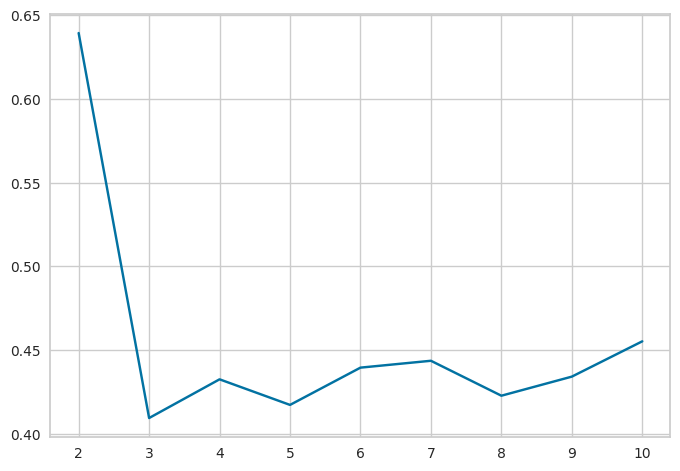

In [233]:
'''Because we will use later the silhouette calculation for different dataframes,
    we will create a function 'silhouette_calc' that will calculate the silhouette for a given dataframe.'''

# The function takes a dataframe as an input and returns a list of silhouette values for different number of clusters
def silhouette_calc(df):
    silhouettes = []

    for k in range (2, 11):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
        cluster_assignments = kmeans.fit_predict(df)
        silhouettes.append(silhouette_score(df, cluster_assignments))
    
    return silhouettes

# Calculate the silhouette for the scaled data of cars
silhouettes = silhouette_calc(cars_scaled)

# Plot the silhouette for different number of clusters
plt.plot(range(2,11), silhouettes)

The y-axis shows us the value of the silhouette coefficient and the x-axis shows us the number of clusters that we want to have. The optimal number of clusters is usually the one that has the highest silhouette score. The cluster's silhouette score should ideally be > 0.7. The cluster that has the coefiicient < 0.5 has an unsuable structure.

In this case, the optimal number of clusters is 2. The silhouette coefficient for 2 clsuters is apx. 0.64, which is not ideal, but is still OK (> 0.5).

We will try to come up with a better silhouette coefficient using different techniques, but for now we will use 2 clusters.

The silhouette coefficient was calculated for the whole, 5 dimensional (number of columns after preparing dataset) dataset. That is why the clustering algorithms will be applied to the whole dataset. It will be difficult to visualize the data in 5 dimensions, that is why after running the algorithms we will look atsome interesting values.

# K-Means

Now we will run the K-Means algorithm on the dataset. The number of clusters will be 2, as it was calculated above. We will also vizualize how many values of clusters have the average or above average values of the silhouette coefficient.

To do so, we will use a function, because this function will be used later for other features and clusters.

In [234]:
#  The functions takes kmeans, the dataframe and returns the cluster assignments, als visualizing the silhouette
def plot_clusters_with_centers(kmeans, X):

    plt.figure(figsize=(8,8))
    cluster_assignments = kmeans.fit_predict(X)

    visualizer = SilhouetteVisualizer(kmeans, is_fitted=True)

    visualizer.fit(X) #fit the data to the visualizer
    visualizer.finalize()
    print(f'Silhoutte score: {visualizer.silhouette_score_}')
    visualizer.show()

    return cluster_assignments

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Silhoutte score: 0.6392663578764872


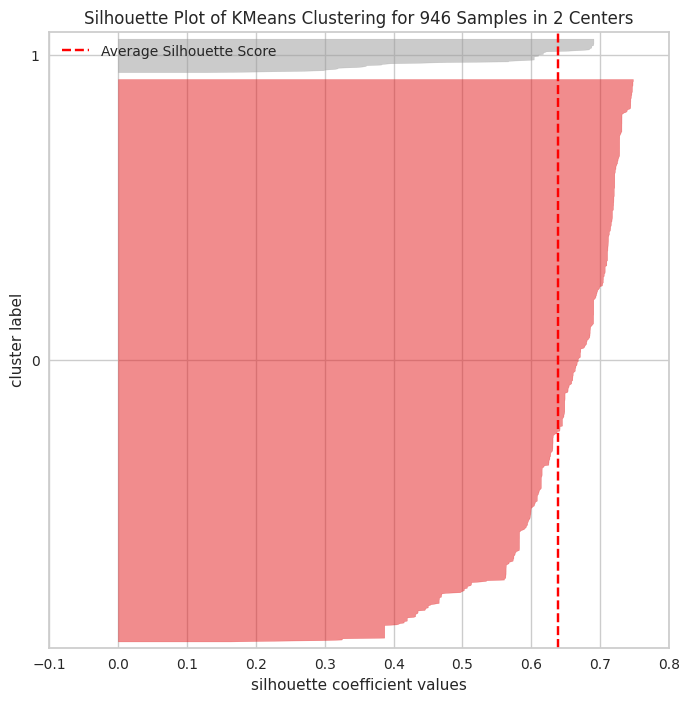

In [235]:
# Initialize the KMeans algorithm with 2 clusters, random state equals 1 for reproducibility
kmeans = KMeans(n_clusters=2, random_state=1)

# Use the function above
k_labels = plot_clusters_with_centers(kmeans, cars_scaled)

We can now see on the graph that a lot of datapoints in both clusters have the silhouette value(x-axis) lower than average, meaning that even though they are clustered, the structure  of the clusters is not strong.

Let's look at the cluster centers, to have an idea of how the average representative of the clusters look like.

We need to scale back the dataset to get the actual values of the features. 

In [236]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[4.27264574e+00, 5.52823991e+02, 4.80774664e+02, 3.65504484e+00,
        1.81087414e+05],
       [6.44444444e+00, 1.24692593e+03, 1.02338889e+03, 2.51481481e+00,
        2.96694444e+06]])

The result is given for the columns: Engine Size (L), Horsepower, Torque (lb-ft), 0-60 MPH Time (seconds), Price (in USD)

The first data cluster's average representative has the values of apx. 4.3 L of engine, 553 Horsepower, 481 Torque, 3.66 seconds for 0-60 MPH Time and costs around 181,087 USD.

The second data cluster's average representative has the values of apx. 6.4 L of engine, 125 Horsepower, 1023,4 Torque, 2.52 seconds for 0-60 MPH Time and costs around 2,966,944 USD.

Based on these values the company can have a more or less clear ideaa where their car models belong to.

# Expectation-Maximization (EM) Algorithm

To have a better picture of clustering, and maybe to come up with better clusters we will use another clustering technique called EM Algorithm.

We will still use our silhouette coefficient for the number of clusters here, so the number of clusters will still be 2. Let's see if the average representatives will differ a lot.

To calculate the clusters, we will need the Gaussian Mixture to assign a point of our dataset to one of the clusters. Cluster assignments are based on the most likely distribution, an element is generated from.

In [237]:
from sklearn.mixture import GaussianMixture

# separate the features from the target variable
X = cars_scaled.to_numpy()

# create an instance of GaussianMixture
gm = GaussianMixture(n_components=2)

# assign every point to a cluster
cluster_assignments=gm.fit_predict(X)
cluster_assignments

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Let's see the average representatives of the clusters.

In [238]:
scaler.inverse_transform(gm.means_)

array([[4.27506077e+00, 5.51150116e+02, 4.79718661e+02, 3.66171016e+00,
        1.73436715e+05],
       [6.18587717e+00, 1.20028826e+03, 9.83212476e+02, 2.53379292e+00,
        2.79348354e+06]])

The result is given again for the columns: Engine Size (L), Horsepower, Torque (lb-ft), 0-60 MPH Time (seconds), Price (in USD)

The first data cluster's average representative has the values of apx. 4 L of engine, 510 Horsepower, 459 Torque, 3.79 seconds for 0-60 MPH Time and costs around 128,720 USD.

The second data cluster's average representative has the values of apx. 5.6 L of engine, 857 Horsepower, 681,4 Torque, 2.93 seconds for 0-60 MPH Time and costs around 1,021,448 USD.

Now the average representative of the clusters have slightly different values. This means that some of the points (every entry, or row of the dataset) in these clusters could be assigned to the other cluster in the other algorithm.

The visualization of the clusters is still not possible, because the dataset has 5 dimensions. It is technically possible but we would not understand and differ it.

This is why we will go to some techniques of dimensionality reduction.

# Dimensionality Reduction

### Variance Threshold

One possible technique of dimensionality reduction is Variance Threshold. It is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold.

To use it,we simply can call var() function on our scaled dataset.

In [239]:
cars_scaled.var()

Engine Size (L)            0.027304
Horsepower                 0.015775
Torque (lb-ft)             0.010526
0-60 MPH Time (seconds)    0.023584
Price (in USD)             0.017582
dtype: float64

We can see the variance of different columns. To pick up some we need to set a threshold. Let's set it to 0.02.

In [240]:
# Initialize the VarianceThreshold
vr = VarianceThreshold(threshold=0.02)

# Fit the VarianceThreshold to the scaled dataset
cars_new = vr.fit_transform(cars_scaled)

# Create a dataframe with the new data
selected_features = vr.get_feature_names_out()
cars_new = pd.DataFrame(cars_new, columns = selected_features)
cars_new

,Engine Size (L),0-60 MPH Time (seconds)
0,0.357143,0.468085
1,0.619048,0.212766
2,0.464286,0.255319
3,0.619048,0.297872
4,0.476190,0.191489
...,...,...
941,0.476190,0.382979
942,0.952381,0.127660
943,0.595238,0.148936
944,0.476190,0.191489


As we can see, the variance threshold suggested to take the columns Engine Size and 0-60 MPH Time.

Let's calculate the silhouette score for these two columns.

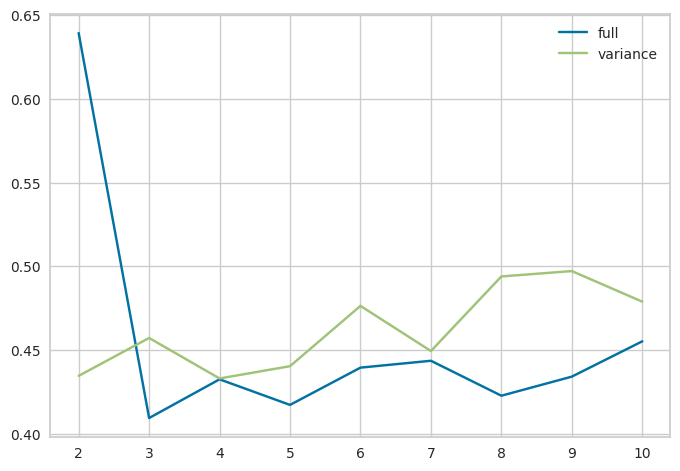

In [241]:
silhouette_var = silhouette_calc(cars_new)
plt.plot(range(2, 11), silhouettes, label = "full")
plt.plot(range(2, 11), silhouette_var, label = "variance")
plt.legend()

As we can see, the silhouette score for variance is even lower than for the whole dataset at k = 2 (x-axis). For all other k-s, the silhouette coefficient is lower than 0.5 This means that the variance threshold is not a good technique for this dataset.

### Mutual information-based feature selection

Another technique is Mutual information-based feature selection. This technique was taken with the help of ChatGPT. The following code is also the adjusted version of the ChatGPT code.

This selection technique is based on the concept of mutual information. It measures the reduction in uncertainty for one variable given a known value of the other variable.

With the help of this technique and some domain knowledge, we can select the features that are most relevant to the target variable.

For the company, one of the most important features is the price of the car. That is why we will use the price as the target variable and see which features are most relevant to it.

In [242]:
from sklearn.feature_selection import mutual_info_regression

# Load the data into X and y
X = cars_scaled.drop('Price (in USD)', axis=1)  # Drop the 'Price' column from the DataFrame to get the features
y = cars_scaled['Price (in USD)']  # Select the 'Price' column as the target variable

# Calculate mutual information scores between features and target variable
mutual_info = mutual_info_regression(X, y)

# Sort the mutual information scores in descending order
sorted_mi = sorted(list(zip(X.columns, mutual_info)), key=lambda x: x[1], reverse=True)

# Select the top k features based on their mutual information scores
k = 2  # Set the number of top features to select. We want to choose most relevant, and not all 4, because it would make no sense.
selected_features = [f[0] for f in sorted_mi[:k]]

# Print the selected features
print('Selected features:', selected_features)

Selected features: ['Horsepower', 'Torque (lb-ft)']


As we can see, the technique suggested to take the columns Horsepower and Torque and 0-60 MPH Time as the most relevant features to the price.

We will run them both together and separately for the Price feature.

We now again calculate our silhouette score using the function and compare it to the full dataset.

In [243]:
# calculate the silhouette for the Horsepower and Price
silhouettes_HP = silhouette_calc(cars_scaled[['Horsepower', 'Price (in USD)']])

# calculate the silhouette for the Torque, Horsepower and Price
silhouettes_THP = silhouette_calc(cars_scaled[['Torque (lb-ft)', 'Horsepower', 'Price (in USD)']])

# calculate the silhouette for the Torque and Price
silhouettes_TP = silhouette_calc(cars_scaled[['Torque (lb-ft)', 'Price (in USD)']])


Now let's visualize it.

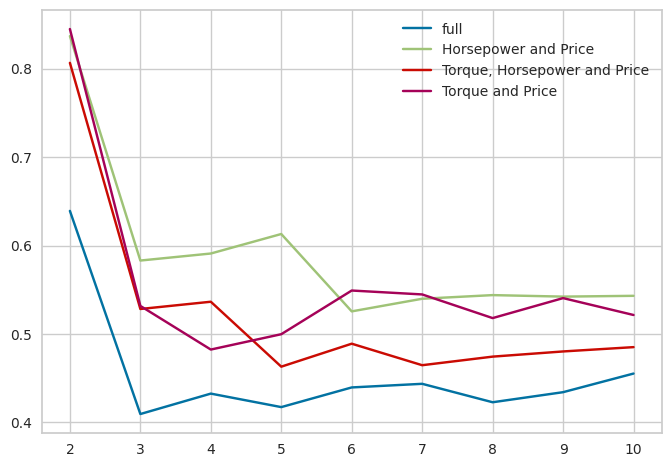

In [244]:
plt.plot(range(2, 11), silhouettes, label = "full")
plt.plot(range(2, 11), silhouettes_HP, label="Horsepower and Price")
plt.plot(range(2, 11), silhouettes_THP, label="Torque, Horsepower and Price")
plt.plot(range(2, 11), silhouettes_TP, label="Torque and Price")
plt.legend()

We can see that the adjusted datasets have a way higher silhouette score meaning that the clustering is better. We now use even 3 clusters. But let's go with our 2 clusters since it has a higher value.

### Principal Component Analysis (PCA)

Another technique of dimensionality reduction is Principal Component Analysis (PCA). It is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

In [245]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
cars_scaled.cov()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
Engine Size (L),0.027304,0.012133,0.010245,-0.009147,0.008686
Horsepower,0.012133,0.015775,0.011852,-0.014266,0.013126
Torque (lb-ft),0.010245,0.011852,0.010526,-0.010579,0.010011
0-60 MPH Time (seconds),-0.009147,-0.014266,-0.010579,0.023584,-0.009685
Price (in USD),0.008686,0.013126,0.010011,-0.009685,0.017582


We see non-zero covariance between all featuresmeaning that the features are correlated.

Because data is already scaled we can use PCA directly.

In [246]:
pca=PCA()
pca_transformed=pca.fit_transform(cars_scaled)
df_pca=pd.DataFrame(pca_transformed)
df_pca

,0,1,2,3,4
0,-0.236279,-0.064340,0.026779,0.036873,0.001434
1,0.116919,-0.002437,-0.137445,0.079402,-0.026231
2,0.059573,-0.118081,-0.062539,-0.008291,0.003140
3,0.039874,0.051164,-0.108219,0.070584,-0.024355
4,0.107457,-0.142517,-0.106918,-0.004635,-0.008387
...,...,...,...,...,...
941,-0.064129,-0.023893,-0.023679,-0.004106,0.028514
942,0.916451,0.043210,0.234638,-0.041831,-0.012495
943,0.664931,-0.226068,0.296057,-0.040058,0.034932
944,0.188524,-0.175744,-0.002150,0.037067,-0.015976


We came up with 2 components.

In [247]:
df_pca.cov().round(2)

,0,1,2,3,4
0,0.06,0.00,0.00,0.0,-0.0
1,0.00,0.02,-0.00,0.0,0.0
2,0.00,-0.00,0.01,-0.0,0.0
3,0.00,0.00,-0.00,0.0,0.0
4,-0.00,0.00,0.00,0.0,0.0


[0.66921611 0.18091134 0.11228137 0.0281228  0.00946837]


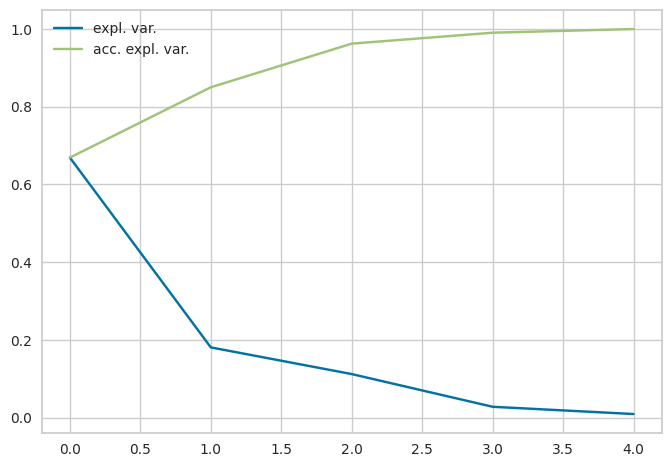

In [248]:
expl_var=pca.explained_variance_ratio_
print(expl_var)
plt.plot(expl_var, label='expl. var.')
plt.plot(np.add.accumulate(expl_var), label='acc. expl. var.')
plt.legend()

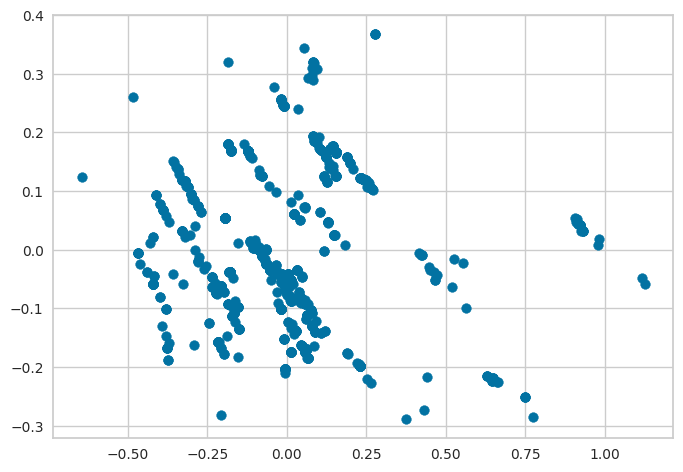

In [249]:
plt.scatter(df_pca.iloc[:,0],df_pca.iloc[:,1])

Let's look at some techniques to help us choos number of principal components that explain most of the values.

In [250]:
from pca import pca

model = pca(n_components=2)

# Fit transform
results = model.fit_transform(cars_scaled)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


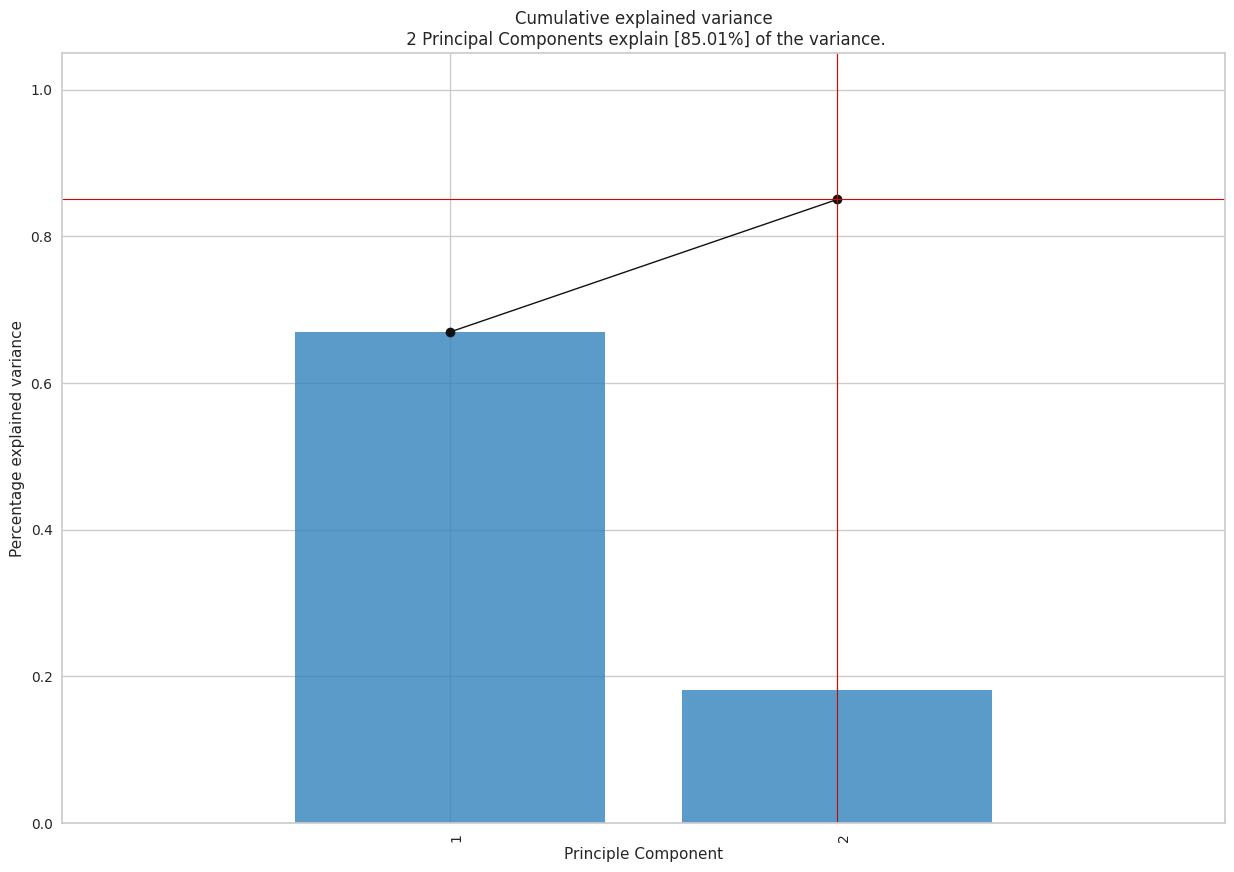

<Figure size 800x550 with 0 Axes>

In [251]:
# explained variance
fig, ax = model.plot()

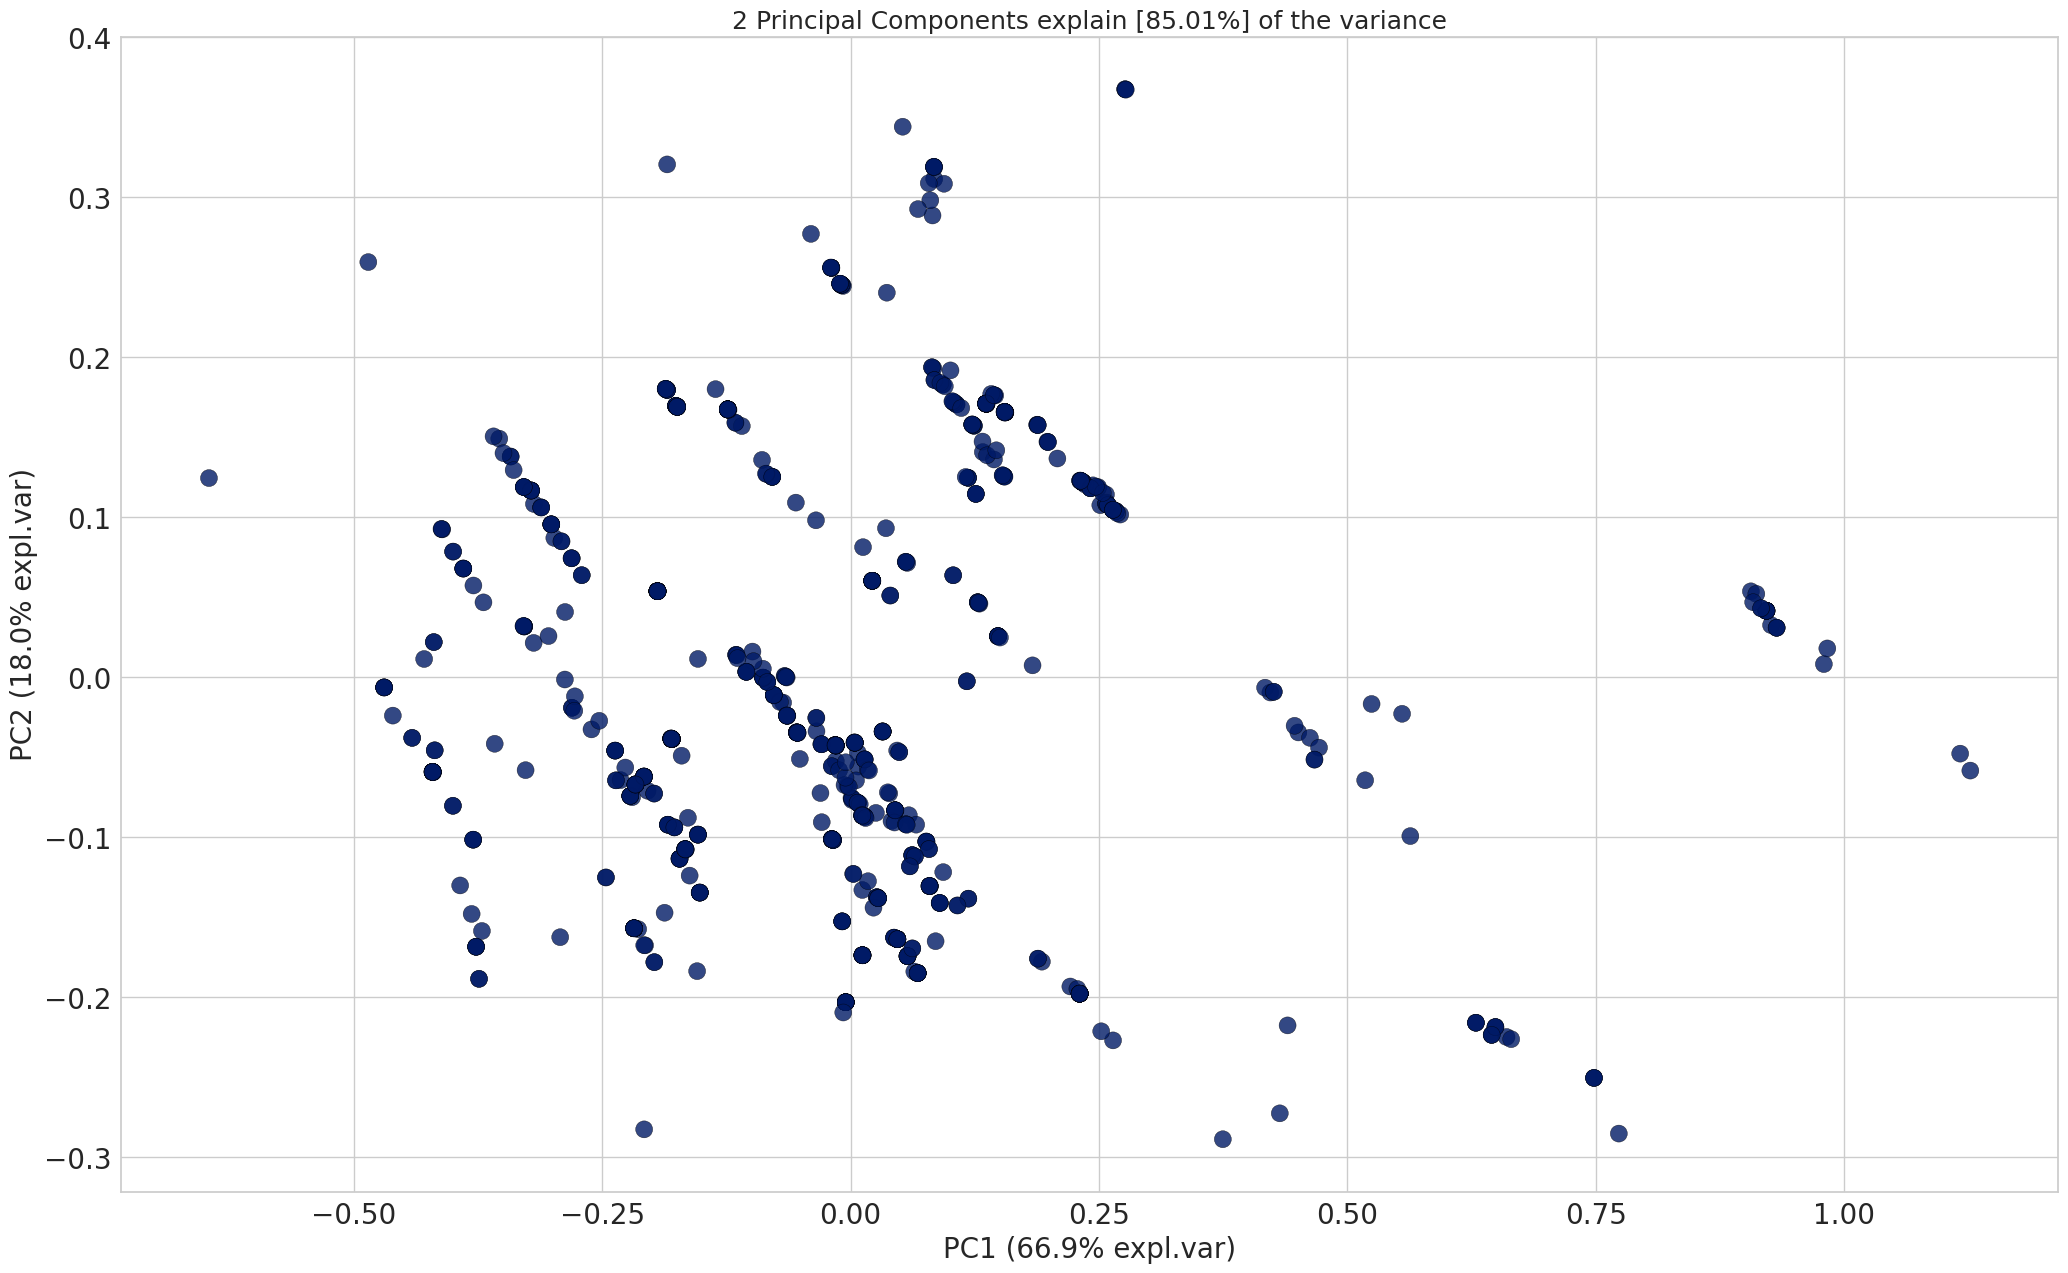

In [252]:
# Scatter first 2 PCs (2 and 3)
fig, ax = model.scatter(legend=False, PC=[0,1])

[pca] >Plot PC1 vs PC2 with loadings.


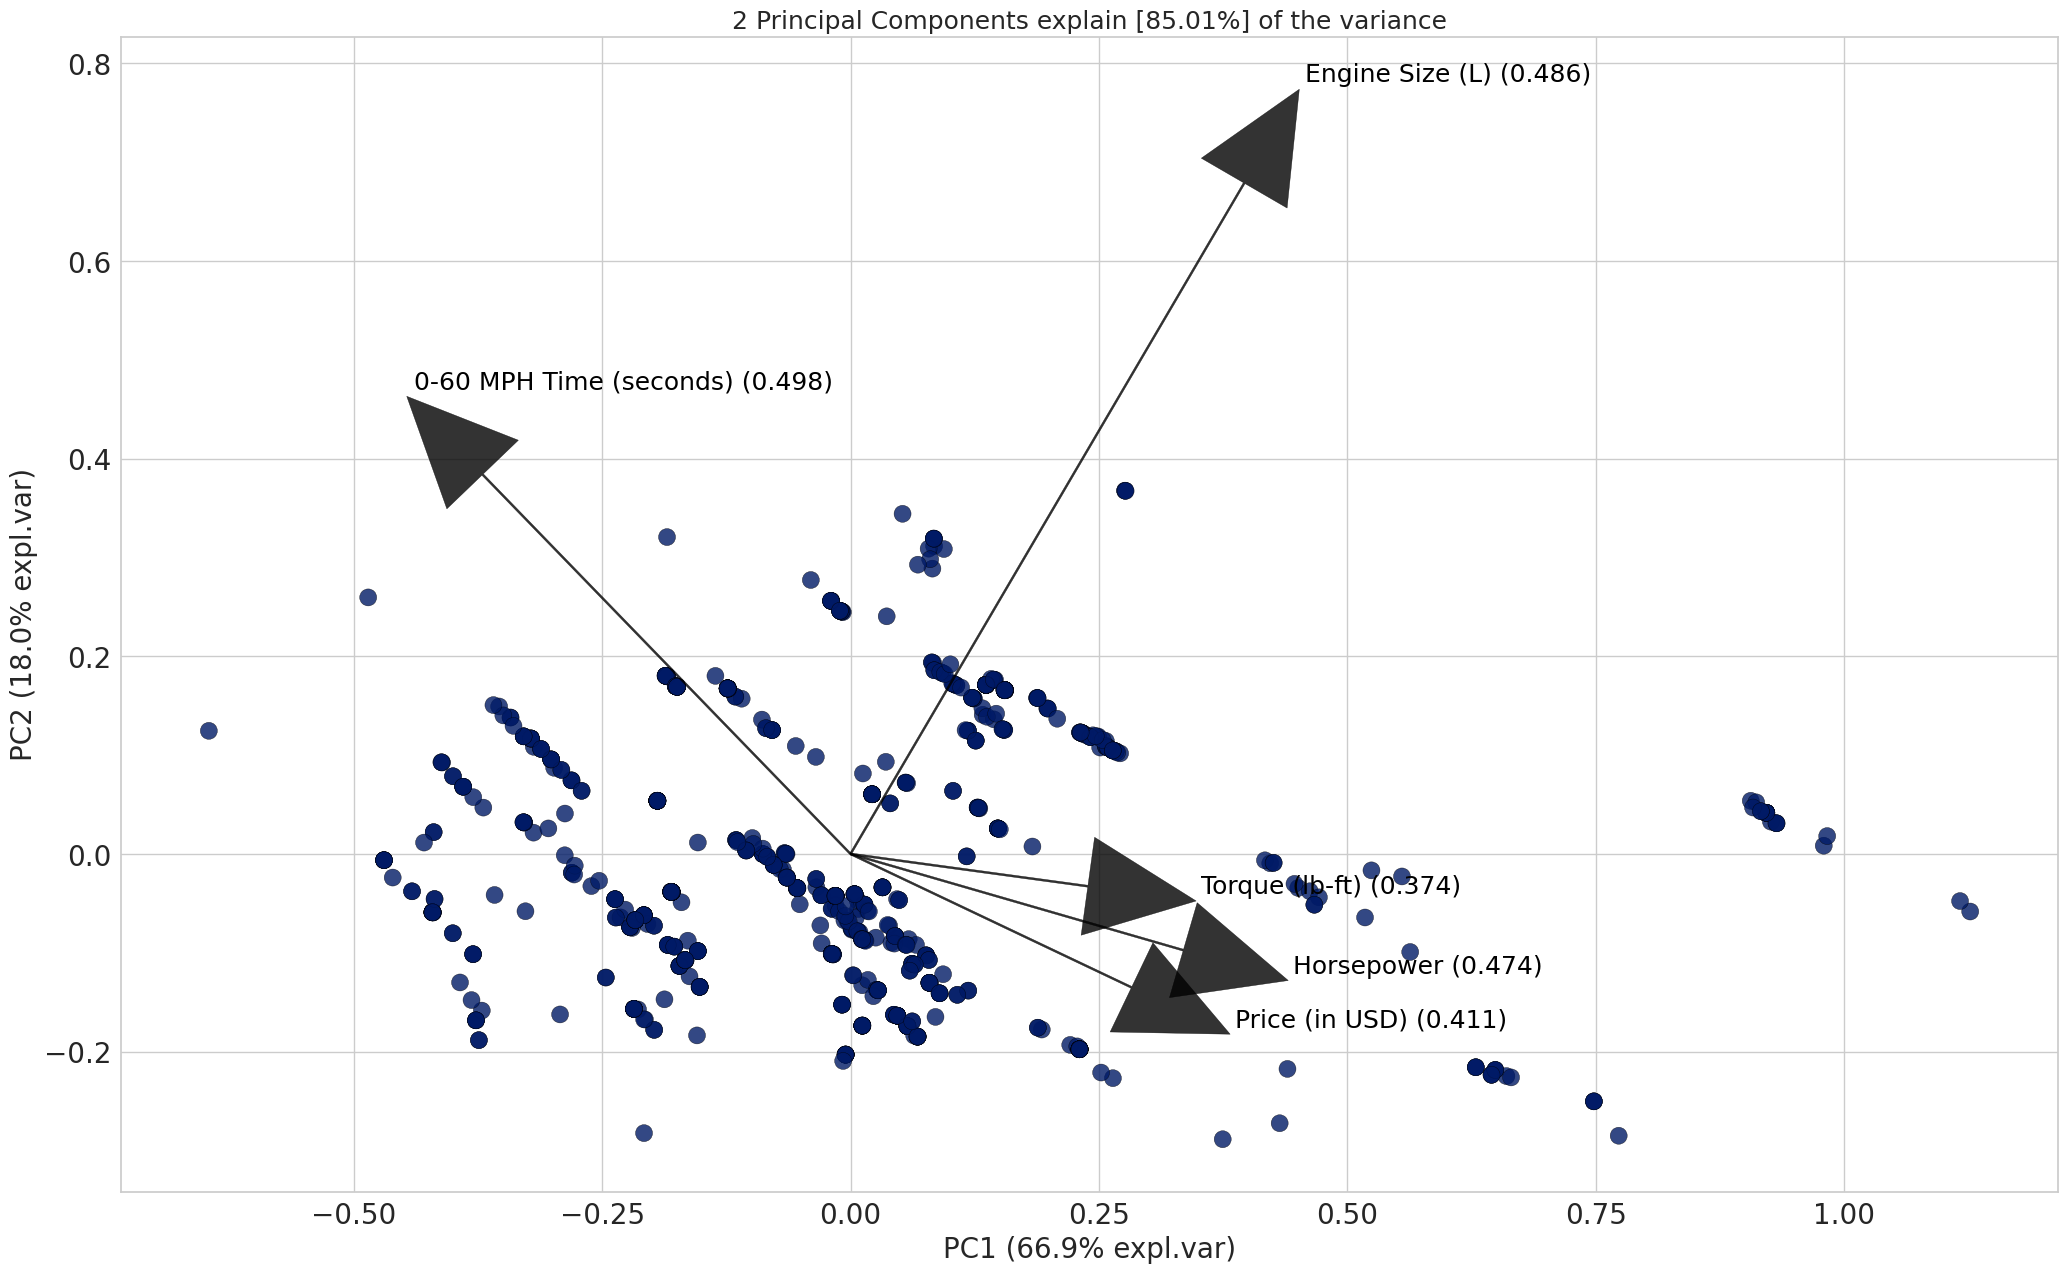

In [253]:
# biplot with number of original features (plot data and loadings)
fig, ax = model.biplot(n_feat=10, legend=False)

In [254]:
dp = cars.dropna().copy()
df = cars_scaled.set_index(dp.index)
model.fit_transform(df)
L = model.results['PC']

[pca] >Cleaning previous fitted model results..
[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [255]:
L.to_numpy()

array([[-0.23627899, -0.06433953],
       [ 0.11691895, -0.00243703],
       [ 0.0595731 , -0.11808123],
       ...,
       [ 0.66493135, -0.22606822],
       [ 0.18852424, -0.17574444],
       [ 0.42601024, -0.00898829]])

We clearly see that going with 2 components is the best choice.

Now let's rerun all of our previous algorithms for PCA to pick up the best one.

# K-Means of PCA

In [256]:
silhouettes_pca = silhouette_calc(L.to_numpy())

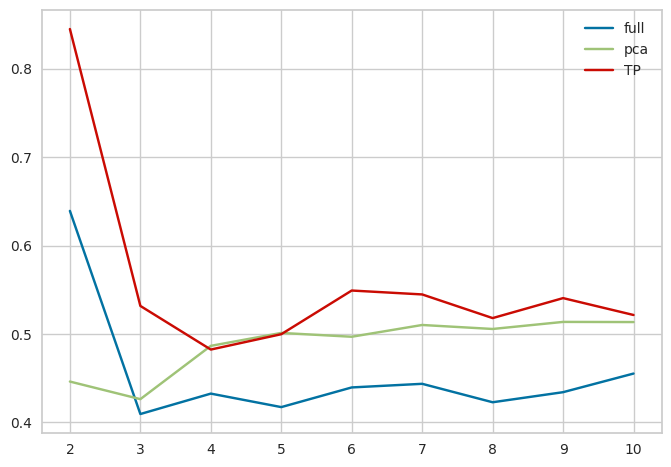

In [257]:
plt.plot(range(2, 11), silhouettes, label = "full")
plt.plot(range(2, 11), silhouettes_pca, label = "pca")
plt.plot(range(2, 11), silhouettes_TP, label = "TP")
plt.legend()
plt.show()

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


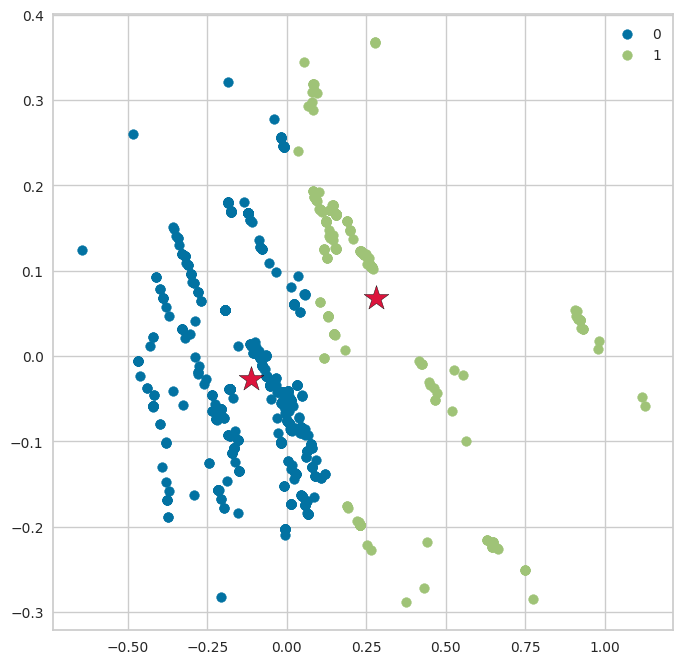

In [258]:
c_a = kmeans.fit_predict(L)

print_clustering(L.to_numpy(), kmeans, c_a)

# EM Algorithm of PCA

In [259]:
def create_ellipse(gmm, ax, n, v0, v1, angle, color, alpha, stretch):
    ell = mpl.patches.Ellipse(
        gmm.means_[n, :2], stretch*v0, stretch*v1, 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(alpha)
    ax.add_artist(ell)


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.5, 1)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.2, 2)
        create_ellipse(gmm, ax, n, v[0], v[1], angle, color, 0.1, 3)
        ax.set_aspect("equal", "datalim")

In [260]:
X = L.to_numpy()

c_a = gm.fit_predict(X)

colors=['darkorange', 'darkmagenta']

em_probs=gm.predict_proba(X)
uncertain_indexes=np.max(em_probs, axis=1)<0.8
np.round(em_probs[uncertain_indexes, :], 2)

array([[0.7 , 0.3 ],
       [0.68, 0.32],
       [0.62, 0.38],
       [0.68, 0.32],
       [0.79, 0.21],
       [0.38, 0.62],
       [0.79, 0.21],
       [0.55, 0.45],
       [0.67, 0.33],
       [0.49, 0.51],
       [0.66, 0.34],
       [0.46, 0.54],
       [0.67, 0.33],
       [0.34, 0.66],
       [0.76, 0.24],
       [0.63, 0.37],
       [0.6 , 0.4 ],
       [0.39, 0.61],
       [0.62, 0.38],
       [0.78, 0.22],
       [0.23, 0.77],
       [0.76, 0.24],
       [0.79, 0.21],
       [0.39, 0.61],
       [0.79, 0.21],
       [0.76, 0.24],
       [0.67, 0.33],
       [0.77, 0.23],
       [0.28, 0.72],
       [0.79, 0.21],
       [0.67, 0.33],
       [0.73, 0.27],
       [0.6 , 0.4 ],
       [0.39, 0.61],
       [0.57, 0.43],
       [0.63, 0.37],
       [0.79, 0.21],
       [0.76, 0.24],
       [0.66, 0.34],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.79, 0.21],
       [0.72, 0.28],
       [0.34, 0.66],
       [0.79, 0.21],
       [0.79, 0.21],
       [0.79, 0.21],
       [0.39,

C:\Users\sayfi\AppData\Local\Temp\ipykernel_15532\870935678.py:2: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(


<Figure size 800x800 with 0 Axes>

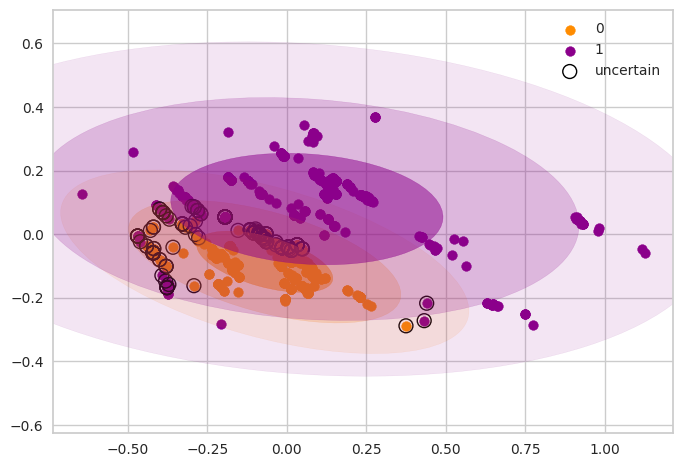

In [261]:
fig=plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
for i in range(0,len(np.unique(c_a))):
    X_sub=X[c_a==i, :]
    plt.scatter(X_sub[:, 0], X_sub[:, 1], c=colors[i], label=i)

X_uncertain=X[uncertain_indexes]
plt.scatter(X_uncertain[:, 0], X_uncertain[:, 1], label="uncertain", s=100,
           linewidth=1, facecolors='none', edgecolors='black')

make_ellipses(gm, ax)
plt.legend()

# Best Clustering Choice

Having some domain knowledge, we would go with clustering the dataset with the help of Mutual information-based feature selection. The reason for this is that the features that were picked up by this technique are the most relevant to the price of the car. And the price is one of the most important features for the company. The best clustering algorithm would be EM Algorithm because it is based on the Gaussian Mixture and it is more flexible than K-Means.

### K-Means of Mutual information-based feature selection

Now let's visualize the clusters since we have only 2 features.

For this, we can create a function.

As we defined and did not change our kmeans algorithm since the last use (number of features = 2), we do not need to do it again.

c:\Users\sayfi\Desktop\Папка для папок\Уни Киль\Uni Projects\Math\mathenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0, 'Torque (lb-ft)')

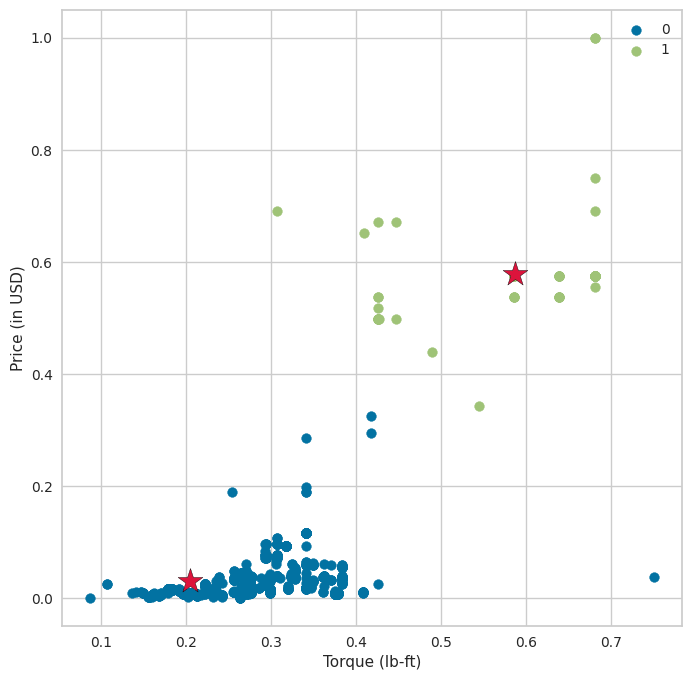

In [262]:
# The function takes a dataframe, kmeans algorithm, cluster assignments of that algoriithm and visualizes the clusters
def print_clustering(X, kmeans, cluster_assignments):
    plt.figure(figsize=(8, 8))

    for i in np.unique(cluster_assignments):
        X_sub=X[cluster_assignments==i, :]
        plt.scatter(X_sub[:, 0], X_sub[:, 1], label=i)
    
    plt.scatter(
        kmeans.cluster_centers_[:, 0], 
        kmeans.cluster_centers_[:, 1],
        s=350, marker='*', c='crimson', edgecolor='black'
    )

    plt.legend()

X = cars_scaled[['Torque (lb-ft)', 'Price (in USD)']].to_numpy()

cluster_assignments = kmeans.fit_predict(cars_scaled[['Horsepower', 'Price (in USD)']])
    
print_clustering(X, kmeans, cluster_assignments)
plt.ylabel('Price (in USD)')
plt.xlabel('Torque (lb-ft)')

Now we finally can see our clusters and draw some conclusions out of it. We can see that for the 1st cluster (cluster '0'), the points are more or less close to each other, meaning that the structure of the cluster is strong. For the 2nd cluster (cluster '1'), the points are more spread out, meaning that the structure of the cluster is not strong. The cars that belong to the 1st cluster are less expensive, compared to the cars from the 2nd cluster. It can be explained by the Torque level that is lower compared to the 2nd cluster. However, we can also see that the only car that has the highest Torque number, belongs to the 1st cluster and not the 2nd one. This car can have other charachteristics that could further be investigated that had an impact for cluster allocation.  

If the comapny compare their cars charechteristics based on Price and Torque, they can easily refer to this visualiztion. It was also found out the they have the best corellation and silhouette coefficient.

The company can possibly also adjust their picing strategy or marketing based on this visualization. They can also see which cars are the most popular and which are not.